<a href="https://colab.research.google.com/github/cashhollister2u/cashhollister2u/blob/main/Cash_Hollister.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os,random
from scipy.signal import spectrogram
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from scipy.io import wavfile
import numpy as np
from PIL import Image # convert any numpy to an image
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# [Sources]
- Jett Hollister
  - Credentials:
    - "AI/ML Subject Matter Expert"
  - Project Input:
    - Stacking training and validation data into a single tensor in memory. Eliminates the model training bottleneck associated with colab reading each file when training the models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# [Note] The "data_x" directory had to be moved to my google drive and the training needed to be exeuted via google colab to make training more than 1 epoch realistic.

# 0. Functions

In [ ]:
def chunk_audio(audio_data, sample_rate, chunk_duration=3.0):
    """

    Split audio data into chunks of specified duration

    Part of organize_model_data function.

    """
    # Handle stereo audio by taking the first channel or converting to mono
    if len(audio_data.shape) > 1:
        audio_data = audio_data[:, 0]  # Take first channel if stereo

    # Convert to float if necessary
    if audio_data.dtype != np.float64:
        audio_data = audio_data.astype(np.float64)

    chunk_size = int(sample_rate * chunk_duration)
    chunks = []

    for i in range(0, len(audio_data), chunk_size):
        chunk = audio_data[i:i + chunk_size]
        # Only process chunks that are exactly the target duration
        # or pad shorter chunks at the end
        if len(chunk) == chunk_size:
            chunks.append(chunk)
        elif len(chunk) > sample_rate * 1.0:  # Only keep chunks longer than 1 second
            # Pad the last chunk to maintain consistent duration
            padded_chunk = np.pad(chunk, (0, chunk_size - len(chunk)), mode='constant')
            chunks.append(padded_chunk)

    return chunks

def get_file_count(dir, percent_val=10):
    """

    Get the total number of files in a directory and calculate the number of files for validation.

    Part of organize_model_data function.

    """
    file_count = os.listdir(dir).__len__()
    validation_count = file_count // percent_val
    return file_count, validation_count

def move_validation_files(src_dir, dist_dir, percent_val=10):
    """

    Move a percentage of files from source directory to destination directory for validation.

    Part of organize_model_data function.

    """
    file_count, validation_count = get_file_count(src_dir, percent_val)
    print(f"Total files: {file_count}, Validation files: {validation_count}")
    files = os.listdir(src_dir)
    random.shuffle(files)
    for i in range(validation_count):
        file = files[i]
        src = os.path.join(src_dir, file)
        dst = os.path.join(dist_dir, file)
        os.rename(src, dst)
    return file_count, validation_count

def generate_spectrograms(training_dir,file_path, x, fs):
    """

    Generate a spectrogram from audio data and save it as an image.

    Part of organize_model_data function.

    """
    # We need to create parmeters for the spectrogram
    freq_min=10 # minimum frequency
    freq_max=2500 # maximum frequency
    window_size=1024
    overlapp=800
    n_fft=1024*4  #2^10
    f,t,S=spectrogram(x,fs,nperseg=window_size,noverlap=overlapp,nfft=n_fft) # convert sound to spectrogram
    f_mask=(f>=freq_min)&(f<=freq_max)
    sxx=S[f_mask,:]
    G=10*np.log10(sxx+1e-8) # add in error to avoid log(0) [infinity]
    # normalize the spectrogram
    norm=Normalize(vmin=np.min(G),vmax=np.max(G))
    G_normalized=norm(G)
    # convert spectrogram to image
    G_colormap=plt.cm.jet( G_normalized)
    G_image=(G_colormap[:,:,:3]*255).astype(np.uint8)
    G_resized=Image.fromarray(G_image).resize((224,224)) # resize to 224x224 for model input as specified in lecture
    output_file=os.path.join(training_dir,os.path.basename(file_path).replace('.wav','.png'))
    G_resized.save(output_file)

def organize_model_data(src_dir, training_dir, val_dir, percent_val=10, chunck_audio=False):
    """

    Main function to organize audio data into training and validation sets.

    """
    # verify directories
    os.makedirs(src_dir, exist_ok=True)
    os.makedirs(training_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for file in os.listdir(src_dir):
        file_path= os.path.join(src_dir,file) # generate file path
        print(file_path)
        fs,x=wavfile.read(file_path) # read wave file

        if chunck_audio:
            audio_chunks = chunk_audio(x,fs)
            for chunk_index, chunk in enumerate(audio_chunks):
                # drop the file ext
                base_name = os.path.basename(file_path).replace('.WAV', '')
                # rename and add chunk index
                upd_file_path = os.path.join(src_dir, f'{base_name}_chunk_{chunk_index:03d}.wav')
                print(upd_file_path)
                generate_spectrograms(training_dir,upd_file_path, chunk, fs)
        else:
            generate_spectrograms(training_dir,file_path, x, fs)

    file_count, validation_count = move_validation_files(training_dir, val_dir, percent_val)
    return file_count, validation_count

def train_model(model, optimizer, train_loader, val_loader, num_epochs, model_name, device):
    """

    Main function to train models.


    """
    # Initialize models, loss function, and optimizer
    criterion = nn.CrossEntropyLoss()
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_accuracy = []
    epoch_recall = []
    epoch_precision = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Training {model_name} Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        accuracy = correct / total * 100
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        cm = confusion_matrix(all_labels, all_preds)
        print(f"{model_name} Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%, Val Precision: {precision:.2f}%, Val Recall: {recall:.2f}% \n"
              "Confusion Matrix:\n", cm)

        # Store epoch metrics to be graphed later
        epoch_train_loss.append(train_loss)
        epoch_val_loss.append(val_loss)
        epoch_accuracy.append(accuracy)
        epoch_precision.append(precision)
        epoch_recall.append(recall)

    return epoch_train_loss, epoch_val_loss, epoch_accuracy, epoch_precision, epoch_recall


def plot_loss_stats(vit_stat, eff_stat, stat_name):
  # Loss curves over epochs
  time = range(len(vit_stat))
  plt.plot(time, vit_stat, label='VIT')
  plt.plot(time, eff_stat, label='EFF')
  plt.xlabel("Epoch")
  plt.ylabel(stat_name)
  plt.title(f"{stat_name} Over Epochs")
  plt.legend()
  plt.show()





# 1. Data Understanding and Preprocessing
- Explore the dataset and examine the duration and structure per class.

- Convert raw audio to spectrograms using STFT.

- Normalize and resize spectrograms to a consistent size (e.g., 128×128).
    - NOTE: Images were resized to 224 X 224 as specified in class that the expected input for the "EfficientNetModel" is 224 x 224

- Split data into training, validation, and testing sets.

- Visualize representative spectrograms for each class.



In [ ]:
# Locations

# Note: Noise Target throws file format errors and only has 2 files #
audio_folders=['noise_target/noise_target数据集/noise_4/DATA0001', 'UUV/uuv_1', 'Kai/KaiYuan数据集/kai_2', 'SpeedBoat/SpeedBoat数据集/speedboat_3'] # , 'noise_target/noise_target数据集/noise_4'
trainting_folders = ['data_x/training/4', 'data_x/training/1', 'data_x/training/2', 'data_x/training/3'] # , 'data_x/training/4'
val_folders = ['data_x/val/4', 'data_x/val/1', 'data_x/val/2', 'data_x/val/3'] # , 'data_x/val/4'

In [ ]:
# generate trainging and validation data
for audio_folder, training_folder, val_folder in zip(audio_folders, trainting_folders, val_folders):
    print(f"Processing {audio_folder} into {training_folder} and {val_folder}")
    if 'noise_target' in audio_folder:
        organize_model_data(audio_folder, training_folder, val_folder, chunck_audio=True)
    else:
        organize_model_data(audio_folder, training_folder, val_folder)

Processing noise_target/noise_target数据集/noise_4/DATA0001 into data_x/training/4 and data_x/val/4
Total files: 0, Validation files: 0
Processing UUV/uuv_1 into data_x/training/1 and data_x/val/1
Total files: 0, Validation files: 0
Processing Kai/KaiYuan数据集/kai_2 into data_x/training/2 and data_x/val/2
Total files: 0, Validation files: 0
Processing SpeedBoat/SpeedBoat数据集/speedboat_3 into data_x/training/3 and data_x/val/3
Total files: 0, Validation files: 0


In [ ]:
# prepare data
data_dir = "/content/drive/MyDrive/data_x"  # Replace with your folder path
# Hyperparameters
batch_size = 8
num_epochs = 10
learning_rate = 0.001
num_classes =4  # Number of subfolders
print(num_classes)

# Image transformations
transform = transforms.Compose([transforms.ToTensor()])

4


In [ ]:
# Load dataset
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "training"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=transform)

# Used to stack the images into a single tensor so that colab doesnt try to read each file when training
def preload_dataset(dataset):
    data, labels = [], []
    count = 0
    for img, label in dataset:
        data.append(img)
        labels.append(label)
        count+=1
        print(f'File: {count + 1}/ {len(dataset)}')
    return torch.stack(data), torch.tensor(labels)

train_data, train_labels = preload_dataset(train_dataset)
val_data, val_labels = preload_dataset(val_dataset)

Streaming output truncated to the last 5000 lines.
File: 683/ 5114
File: 684/ 5114
File: 685/ 5114
File: 686/ 5114
File: 687/ 5114
File: 688/ 5114
File: 689/ 5114
File: 690/ 5114
File: 691/ 5114
File: 692/ 5114
File: 693/ 5114
File: 694/ 5114
File: 695/ 5114
File: 696/ 5114
File: 697/ 5114
File: 698/ 5114
File: 699/ 5114
File: 700/ 5114
File: 701/ 5114
File: 702/ 5114
File: 703/ 5114
File: 704/ 5114
File: 705/ 5114
File: 706/ 5114
File: 707/ 5114
File: 708/ 5114
File: 709/ 5114
File: 710/ 5114
File: 711/ 5114
File: 712/ 5114
File: 713/ 5114
File: 714/ 5114
File: 715/ 5114
File: 716/ 5114
File: 717/ 5114
File: 718/ 5114
File: 719/ 5114
File: 720/ 5114
File: 721/ 5114
File: 722/ 5114
File: 723/ 5114
File: 724/ 5114
File: 725/ 5114
File: 726/ 5114
File: 727/ 5114
File: 728/ 5114
File: 729/ 5114
File: 730/ 5114
File: 731/ 5114
File: 732/ 5114
File: 733/ 5114
File: 734/ 5114
File: 735/ 5114
File: 736/ 5114
File: 737/ 5114
File: 738/ 5114
File: 739/ 5114
File: 740/ 5114
File: 741/ 5114
File:

In [ ]:
# Create data loaders

train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(val_data, val_labels), batch_size=32, shuffle=False)

# 2. Baseline Models (Without Augmentation)

### 2.1 CNN Model
- Design and train a CNN to classify ship types using spectrogram inputs.
- Evaluate using:
    - Accuracy
    - Precision
    - Recall
    - Confusion Matrix

In [ ]:
# design your model
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### [Note] train_model() evaluates using: Accuracy, Precision, Recall, and Confusion Matrix

In [ ]:
# Initialize models, loss function, and optimizer
efficientnet_model = EfficientNetModel(num_classes).to(device)
efficientnet_optimizer = optim.Adam(efficientnet_model.parameters(), lr=learning_rate)
eff_epoch_train_loss, eff_epoch_val_loss, eff_epoch_accuracy, eff_epoch_precision, eff_epoch_recall = train_model(efficientnet_model, efficientnet_optimizer, train_loader, val_loader, num_epochs, "EfficientNet", device)

Training EfficientNet Epoch 1/10: 100%|██████████| 160/160 [00:23<00:00,  6.89it/s]


EfficientNet Epoch 1/10, Train Loss: 0.6554, Val Loss: 0.3992, Val Accuracy: 82.54%, Val Precision: 0.87%, Val Recall: 0.83% 
Confusion Matrix:
 [[ 58  13  19   0]
 [  0 241  25   0]
 [  9  33 149   0]
 [  0   0   0  20]]


Training EfficientNet Epoch 2/10: 100%|██████████| 160/160 [00:23<00:00,  6.80it/s]


EfficientNet Epoch 2/10, Train Loss: 0.3412, Val Loss: 0.3204, Val Accuracy: 84.66%, Val Precision: 0.84%, Val Recall: 0.87% 
Confusion Matrix:
 [[ 75   7   8   0]
 [  1 252  13   0]
 [ 26  30 133   2]
 [  0   0   0  20]]


Training EfficientNet Epoch 3/10: 100%|██████████| 160/160 [00:23<00:00,  6.73it/s]


EfficientNet Epoch 3/10, Train Loss: 0.2744, Val Loss: 0.2652, Val Accuracy: 85.54%, Val Precision: 0.89%, Val Recall: 0.86% 
Confusion Matrix:
 [[ 69   3  18   0]
 [  0 263   3   0]
 [ 13  45 133   0]
 [  0   0   0  20]]


Training EfficientNet Epoch 4/10: 100%|██████████| 160/160 [00:23<00:00,  6.73it/s]


EfficientNet Epoch 4/10, Train Loss: 0.2643, Val Loss: 0.2517, Val Accuracy: 85.71%, Val Precision: 0.86%, Val Recall: 0.88% 
Confusion Matrix:
 [[ 71   0  19   0]
 [  3 230  31   2]
 [ 12  14 165   0]
 [  0   0   0  20]]


Training EfficientNet Epoch 5/10: 100%|██████████| 160/160 [00:24<00:00,  6.66it/s]


EfficientNet Epoch 5/10, Train Loss: 0.2269, Val Loss: 0.2062, Val Accuracy: 88.36%, Val Precision: 0.93%, Val Recall: 0.89% 
Confusion Matrix:
 [[ 72   2  16   0]
 [  0 252  14   0]
 [  1  33 157   0]
 [  0   0   0  20]]


Training EfficientNet Epoch 6/10: 100%|██████████| 160/160 [00:24<00:00,  6.60it/s]


EfficientNet Epoch 6/10, Train Loss: 0.1983, Val Loss: 0.2900, Val Accuracy: 86.07%, Val Precision: 0.88%, Val Recall: 0.88% 
Confusion Matrix:
 [[ 79   2   9   0]
 [  0 254  12   0]
 [ 20  36 135   0]
 [  0   0   0  20]]


Training EfficientNet Epoch 7/10: 100%|██████████| 160/160 [00:24<00:00,  6.52it/s]


EfficientNet Epoch 7/10, Train Loss: 0.2186, Val Loss: 0.1936, Val Accuracy: 88.71%, Val Precision: 0.91%, Val Recall: 0.90% 
Confusion Matrix:
 [[ 72   1  17   0]
 [  1 235  30   0]
 [ 11   4 176   0]
 [  0   0   0  20]]


Training EfficientNet Epoch 8/10: 100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


EfficientNet Epoch 8/10, Train Loss: 0.1910, Val Loss: 0.2592, Val Accuracy: 86.42%, Val Precision: 0.88%, Val Recall: 0.90% 
Confusion Matrix:
 [[ 80   1   9   0]
 [  1 228  37   0]
 [ 23   6 162   0]
 [  0   0   0  20]]


Training EfficientNet Epoch 9/10: 100%|██████████| 160/160 [00:24<00:00,  6.52it/s]


EfficientNet Epoch 9/10, Train Loss: 0.2006, Val Loss: 0.2599, Val Accuracy: 87.83%, Val Precision: 0.89%, Val Recall: 0.88% 
Confusion Matrix:
 [[ 74   5  11   0]
 [  1 244  21   0]
 [ 11  18 161   1]
 [  0   1   0  19]]


Training EfficientNet Epoch 10/10: 100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


EfficientNet Epoch 10/10, Train Loss: 0.1827, Val Loss: 0.2847, Val Accuracy: 85.89%, Val Precision: 0.91%, Val Recall: 0.86% 
Confusion Matrix:
 [[ 65   5  20   0]
 [  0 262   4   0]
 [  3  48 140   0]
 [  0   0   0  20]]


### 2.2 Transformer Model
- Implement a Transformer model suited for image-like input (e.g., Vision Transformer).

- Preprocess data into patches or embeddings as needed.

- Train and evaluate the model using the same metrics as above.

In [ ]:
# Transfer Learning+ Vision Transformer
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        # Load pretrained Vision Transformer model
        self.model = models.vit_b_16(pretrained=True)

        # Replace the head (classification layer)
        in_features = self.model.heads.head.in_features  # Get input features of the head
        self.model.heads.head = nn.Linear(in_features, num_classes)  # Replace with new classification layer

    def forward(self, x):
        return self.model(x)

In [ ]:
vit_model = ViTModel(num_classes).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 220MB/s]


In [ ]:
vit_optimizer = optim.Adam(vit_model.parameters(), lr=learning_rate)

### [Note] train_model() evaluates using: Accuracy, Precision, Recall, and Confusion Matrix

In [ ]:
# Train Vision Transformer
vit_epoch_train_loss, vit_epoch_val_loss, vit_epoch_accuracy, vit_epoch_precision, vit_epoch_recall = train_model(vit_model, vit_optimizer, train_loader, val_loader, num_epochs, "ViT", device)

Training ViT Epoch 1/10: 100%|██████████| 160/160 [02:46<00:00,  1.04s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ViT Epoch 1/10, Train Loss: 1.1894, Val Loss: 1.2083, Val Accuracy: 49.21%, Val Precision: 0.24%, Val Recall: 0.29% 
Confusion Matrix:
 [[  0  56  34   0]
 [  0 196  70   0]
 [  0 108  83   0]
 [  0  17   3   0]]


Training ViT Epoch 2/10: 100%|██████████| 160/160 [02:48<00:00,  1.06s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ViT Epoch 2/10, Train Loss: 1.1479, Val Loss: 1.1297, Val Accuracy: 46.91%, Val Precision: 0.12%, Val Recall: 0.25% 
Confusion Matrix:
 [[  0  90   0   0]
 [  0 266   0   0]
 [  0 191   0   0]
 [  0  20   0   0]]


Training ViT Epoch 3/10: 100%|██████████| 160/160 [02:49<00:00,  1.06s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ViT Epoch 3/10, Train Loss: 1.1228, Val Loss: 1.1182, Val Accuracy: 48.85%, Val Precision: 0.23%, Val Recall: 0.28% 
Confusion Matrix:
 [[  0  66  24   0]
 [  0 225  41   0]
 [  0 139  52   0]
 [  0  18   2   0]]


Training ViT Epoch 4/10: 100%|██████████| 160/160 [02:49<00:00,  1.06s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ViT Epoch 4/10, Train Loss: 1.1070, Val Loss: 1.1023, Val Accuracy: 48.85%, Val Precision: 0.24%, Val Recall: 0.30% 
Confusion Matrix:
 [[  0  51  39   0]
 [  0 169  97   0]
 [  0  83 108   0]
 [  0  16   4   0]]


Training ViT Epoch 5/10: 100%|██████████| 160/160 [02:50<00:00,  1.06s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ViT Epoch 5/10, Train Loss: 1.1018, Val Loss: 1.1062, Val Accuracy: 50.26%, Val Precision: 0.25%, Val Recall: 0.31% 
Confusion Matrix:
 [[  0  48  42   0]
 [  0 159 107   0]
 [  0  65 126   0]
 [  0  17   3   0]]


Training ViT Epoch 6/10: 100%|██████████| 160/160 [02:50<00:00,  1.06s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ViT Epoch 6/10, Train Loss: 1.0774, Val Loss: 1.0757, Val Accuracy: 53.44%, Val Precision: 0.51%, Val Recall: 0.33% 
Confusion Matrix:
 [[  1  41  48   0]
 [  0 181  85   0]
 [  0  70 121   0]
 [  0  18   2   0]]


Training ViT Epoch 7/10: 100%|██████████| 160/160 [02:50<00:00,  1.07s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ViT Epoch 7/10, Train Loss: 1.0168, Val Loss: 1.0139, Val Accuracy: 53.97%, Val Precision: 0.44%, Val Recall: 0.35% 
Confusion Matrix:
 [[  2  28  60   0]
 [  1 156 109   0]
 [  0  43 148   0]
 [  0  18   2   0]]


Training ViT Epoch 8/10: 100%|██████████| 160/160 [02:50<00:00,  1.06s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ViT Epoch 8/10, Train Loss: 0.9855, Val Loss: 0.9741, Val Accuracy: 55.38%, Val Precision: 0.42%, Val Recall: 0.42% 
Confusion Matrix:
 [[ 40  12  38   0]
 [ 30 126 110   0]
 [ 25  18 148   0]
 [  0  10  10   0]]


Training ViT Epoch 9/10: 100%|██████████| 160/160 [02:50<00:00,  1.07s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ViT Epoch 9/10, Train Loss: 0.9567, Val Loss: 0.9954, Val Accuracy: 54.85%, Val Precision: 0.28%, Val Recall: 0.35% 
Confusion Matrix:
 [[  0  43  47   0]
 [  0 158 108   0]
 [  0  38 153   0]
 [  0  18   2   0]]


Training ViT Epoch 10/10: 100%|██████████| 160/160 [02:50<00:00,  1.07s/it]


ViT Epoch 10/10, Train Loss: 0.9311, Val Loss: 0.8961, Val Accuracy: 58.91%, Val Precision: 0.64%, Val Recall: 0.47% 
Confusion Matrix:
 [[ 23  21  46   0]
 [ 13 148 104   1]
 [  1  31 158   1]
 [  0  13   2   5]]


# 3. Data Augmentation using Generative Models [Optional]

# 4. Retrain and Evaluate with Augmented Data [Optional]

# 5. Comparative Analysis
- Compare the CNN and Transformer models:
    - Without augmentation
- Use tables/plots to summarize metrics for each case.
- Discuss improvements in accuracy or robustness due to augmentation.
- Comment on training stability, overfitting, and generalization.

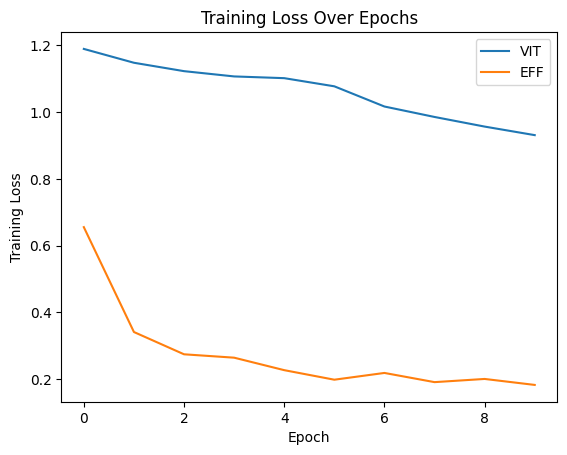

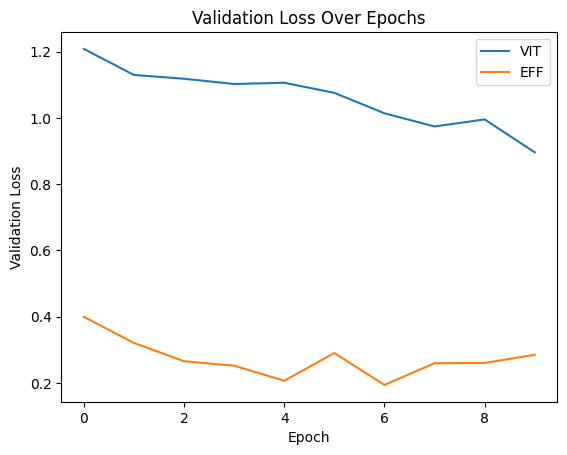

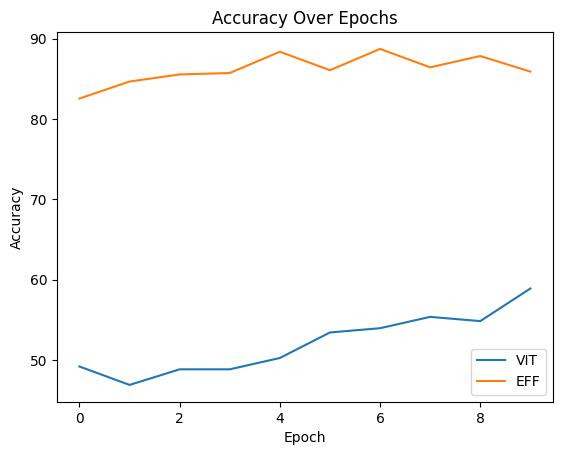

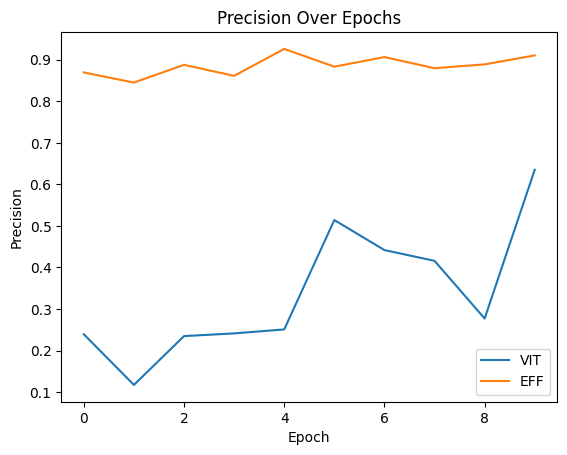

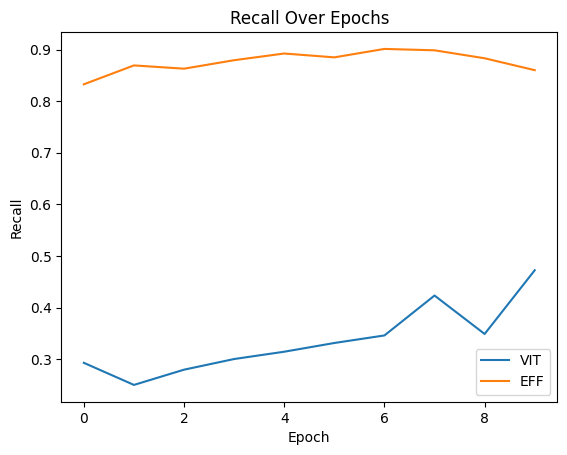

In [ ]:
plot_loss_stats(vit_epoch_train_loss, eff_epoch_train_loss, 'Training Loss')
plot_loss_stats(vit_epoch_val_loss, eff_epoch_val_loss, 'Validation Loss')
plot_loss_stats(vit_epoch_accuracy, eff_epoch_accuracy, 'Accuracy')
plot_loss_stats(vit_epoch_precision, eff_epoch_precision, 'Precision')
plot_loss_stats(vit_epoch_recall, eff_epoch_recall, 'Recall')

# 6. Discussion and Insights
- Role and benefits of spectrogram representation for ship classification.
- Challenges faced in preprocessing and model design.
- Benefits and trade-offs of using VAE vs. Diffusion Models for augmentation.